In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv, GATConv
import random
import matplotlib.pyplot as plt

torch.serialization.add_safe_globals([Data])

In [ ]:
# GNN Model for Embedding Learning

class GNNPrefetch(nn.Module):
    def __init__(self, in_dim, hidden_dim, emb_dim, num_layers=2, dropout=0.3, model_type="sage", heads=4):
        super(GNNPrefetch, self).__init__()
        self.convs = nn.ModuleList()
        self.model_type = model_type.lower()
        self.dropout = dropout

        if self.model_type == "sage":
            conv_class = SAGEConv
        elif self.model_type == "gcn":
            conv_class = GCNConv
        elif self.model_type == "gat":
            conv_class = lambda in_c, out_c: GATConv(in_c, out_c // heads, heads=heads)
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")

        self.convs.append(conv_class(in_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(conv_class(hidden_dim, hidden_dim))
        self.convs.append(conv_class(hidden_dim, emb_dim))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

    def get_embedding(self, x, edge_index):
        # Return node embeddings before the final output layer
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        return x

In [ ]:
def split_dataset(data, train_ratio=0.7, val_ratio=0.15):
    print("Unique src nodes:", len(torch.unique(data.src)))
    print("Unique target nodes:", len(torch.unique(data.y)))
    print("Total nodes:", data.x.size(0))

    num_samples = data.src.size(0)
    indices = list(range(num_samples))
    random.shuffle(indices)

    train_end = int(train_ratio * num_samples)
    val_end = int((train_ratio + val_ratio) * num_samples)

    train_idx = indices[:train_end]
    val_idx = indices[train_end:val_end]
    test_idx = indices[val_end:]

    return train_idx, val_idx, test_idx

In [ ]:
def train_linkpred(model, data, train_idx, optimizer):
    model.train()
    optimizer.zero_grad()

    z = model(data.x, data.edge_index)

    pos_src = data.src[train_idx]
    pos_tgt = data.y[train_idx]

    # Sample random negatives
    neg_tgt = torch.randint(0, z.size(0), pos_tgt.size(), device=z.device)

    # Compute similarity (dot product)
    pos_score = (z[pos_src] * z[pos_tgt]).sum(dim=1)
    neg_score = (z[pos_src] * z[neg_tgt]).sum(dim=1)

    # Contrastive loss: push positive scores higher than negatives
    loss = -torch.log(torch.sigmoid(pos_score - neg_score)).mean()

    loss.backward()
    optimizer.step()

    return loss.item()


In [ ]:
# Evaluation: Top-K Hit Rate

@torch.no_grad()
def evaluate_linkpred(model, data, idx, top_k=5):
    model.eval()
    z = model(data.x, data.edge_index)

    correct = 0
    total = len(idx)

    for s, t in zip(data.src[idx], data.y[idx]):
        scores = (z[s] @ z.T)  # similarity to all nodes
        top_pred = torch.topk(scores, top_k).indices
        if t in top_pred:
            correct += 1

    hit_rate = correct / total
    return hit_rate

Original graph: 648 nodes, 647 edges
Added 5 cross-links. Total edges: 652
✅ Updated GNN Data: x=torch.Size([648, 2]), edges=torch.Size([2, 652])


e:\Research\R004SE-PrefetchingGnn\lab_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


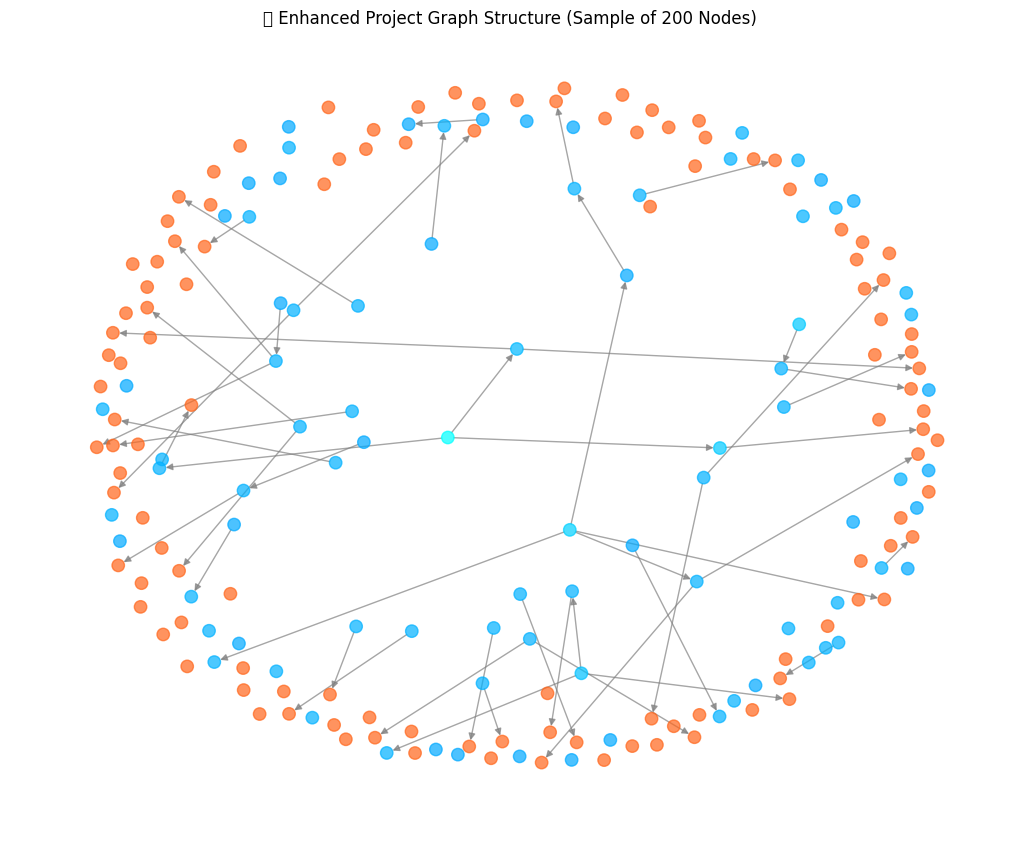

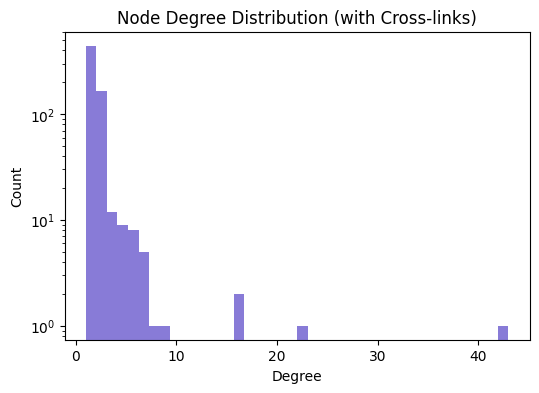

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import random

def load_graph(graph_file):
    return nx.read_gexf(graph_file)

G = load_graph("E:/Research/R004SE-PrefetchingGnn/route-mapper/graph.gexf")
print(f"Original graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

dir_nodes = [n for n, d in G.nodes(data=True)
             if str(d.get("is_directory", "false")).lower() == "true"]
num_cross_links = max(1, len(dir_nodes) // 50)  # ~2% of directories get cross-links

for _ in range(num_cross_links):
    a, b = random.sample(dir_nodes, 2)
    if not G.has_edge(a, b):
        G.add_edge(a, b)
print(f"Added {num_cross_links} cross-links. Total edges: {G.number_of_edges()}")

#  Compute Node Features: Degree + Depth 
def compute_depths(G):
    depths = {}
    roots = [n for n in G.nodes if len(list(G.predecessors(n))) == 0]
    for r in roots:
        for node in nx.descendants(G, r):
            try:
                depths[node] = nx.shortest_path_length(G, source=r, target=node)
            except nx.NetworkXNoPath:
                depths[node] = 0
        depths[r] = 0
    return depths

depths = compute_depths(G)
degrees = [G.degree(n) for n in G.nodes()]
depth_vals = [depths.get(n, 0) for n in G.nodes()]

# Normalize features
deg_tensor = torch.tensor(degrees, dtype=torch.float).unsqueeze(1)
depth_tensor = torch.tensor(depth_vals, dtype=torch.float).unsqueeze(1)
deg_tensor = (deg_tensor - deg_tensor.mean()) / (deg_tensor.std() + 1e-6)
depth_tensor = (depth_tensor - depth_tensor.mean()) / (depth_tensor.std() + 1e-6)
x = torch.cat([deg_tensor, depth_tensor], dim=1)

# Rebuild edge index
node_map = {n: i for i, n in enumerate(G.nodes())}
edges = [(node_map[u], node_map[v]) for u, v in G.edges()]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

data = torch.load("gnn_prefetch_dataset.pt", weights_only=False)
data.x = x  # Replace old one-hot with structural features
data.edge_index = edge_index

print(f"✅ Updated GNN Data: x={data.x.shape}, edges={data.edge_index.shape}")

# Visualize Graph Structure with Highlighted Hubs 
sub_nodes = random.sample(list(G.nodes()), min(200, G.number_of_nodes()))
H = G.subgraph(sub_nodes).copy()

node_deg = dict(G.degree(H.nodes()))
max_deg = max(node_deg.values()) if node_deg else 1

# color: directories blue / files red, brightness = degree
colors = []
for n in H.nodes():
    base_color = "skyblue" if str(G.nodes[n].get("is_directory", "false")).lower() == "true" else "salmon"
    alpha = min(1.0, 0.2 + node_deg[n] / max_deg)  # brighter = higher degree
    colors.append((0, 0.5 + 0.5*alpha, 1, 0.6) if base_color == "skyblue"
                  else (1, 0.4, 0.4*alpha, 0.7))

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, seed=42, k=0.25)
nx.draw(
    H,
    pos,
    node_color=colors,
    with_labels=False,
    node_size=80,
    edge_color="gray",
    alpha=0.7,
)
plt.title("📁 Enhanced Project Graph Structure (Sample of 200 Nodes)")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(degrees, bins=40, color="slateblue", alpha=0.8)
plt.title("Node Degree Distribution (with Cross-links)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

Unique src nodes: 21
Unique target nodes: 28
Total nodes: 648
Train: 651, Val: 139, Test: 140
Epoch 001 | Loss: 0.6922 | Val Top-5 HitRate: 0.5180
Epoch 010 | Loss: 0.0666 | Val Top-5 HitRate: 0.6691
Epoch 020 | Loss: 0.0444 | Val Top-5 HitRate: 0.6978
Epoch 030 | Loss: 0.0153 | Val Top-5 HitRate: 0.7842
Epoch 040 | Loss: 0.0204 | Val Top-5 HitRate: 0.7698
Epoch 050 | Loss: 0.0240 | Val Top-5 HitRate: 0.7914
Epoch 060 | Loss: 0.0159 | Val Top-5 HitRate: 0.9137
Epoch 070 | Loss: 0.0222 | Val Top-5 HitRate: 0.9065
Epoch 080 | Loss: 0.0073 | Val Top-5 HitRate: 0.8489
Epoch 090 | Loss: 0.0140 | Val Top-5 HitRate: 0.8633
Epoch 100 | Loss: 0.0055 | Val Top-5 HitRate: 0.8129
✅ Test Top-5 HitRate: 0.8214
💾 Model saved as gnn_prefetch_linkpred.pt


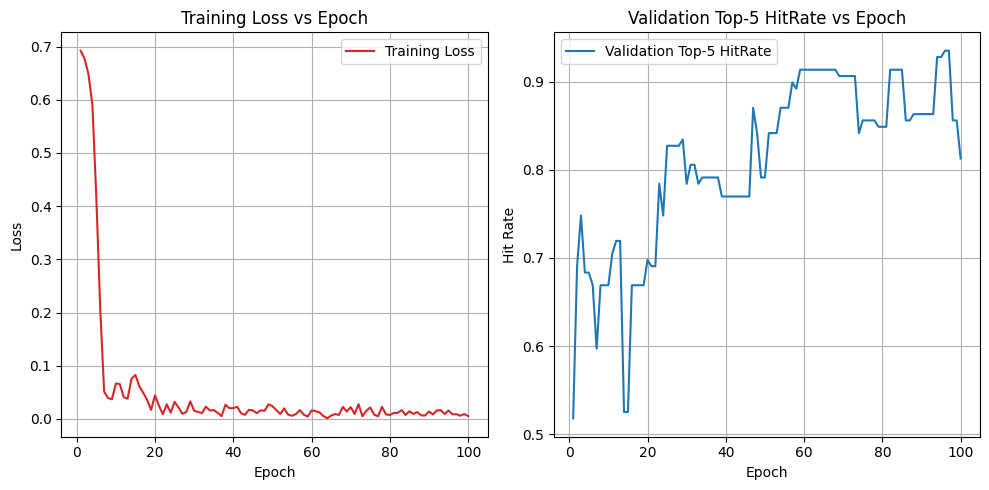

📈 Training graphs saved as training_results.png


In [ ]:
if __name__ == "__main__":
    # Load dataset
    data: Data = torch.load(
        "E:/Research/R004SE-PrefetchingGnn/user-session-sim/gnn_prefetch_dataset.pt",
        weights_only=False
    )

    in_dim = data.x.size(1)
    hidden_dim = 128
    emb_dim = 64 

    model = GNNPrefetch(in_dim, hidden_dim, emb_dim, num_layers=3, model_type="sage")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

    train_idx, val_idx, test_idx = split_dataset(data)
    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

    epochs = 100
    loss_history = []
    val_hit_history = []

    # Training loop
    for epoch in range(1, epochs + 1):
        loss = train_linkpred(model, data, train_idx, optimizer)
        val_hit = evaluate_linkpred(model, data, val_idx, top_k=5)

        loss_history.append(loss)
        val_hit_history.append(val_hit)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Top-5 HitRate: {val_hit:.4f}")

    # Final evaluation on test set
    test_hit = evaluate_linkpred(model, data, test_idx, top_k=5)
    print(f"✅ Test Top-5 HitRate: {test_hit:.4f}")

    # Save model
    torch.save(model.state_dict(), "gnn_prefetch_linkpred.pt")
    print("💾 Model saved as gnn_prefetch_linkpred.pt")

    # Plot training results

    plt.figure(figsize=(10, 5))

    # Plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), loss_history, label="Training Loss", color="tab:red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Epoch")
    plt.grid(True)
    plt.legend()

    # Plot validation Top-5 HitRate
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), val_hit_history, label="Validation Top-5 HitRate", color="tab:blue")
    plt.xlabel("Epoch")
    plt.ylabel("Hit Rate")
    plt.title("Validation Top-5 HitRate vs Epoch")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_results.png", dpi=300)
    plt.show()

    print("📈 Training graphs saved as training_results.png")

e:\Research\R004SE-PrefetchingGnn\lab_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


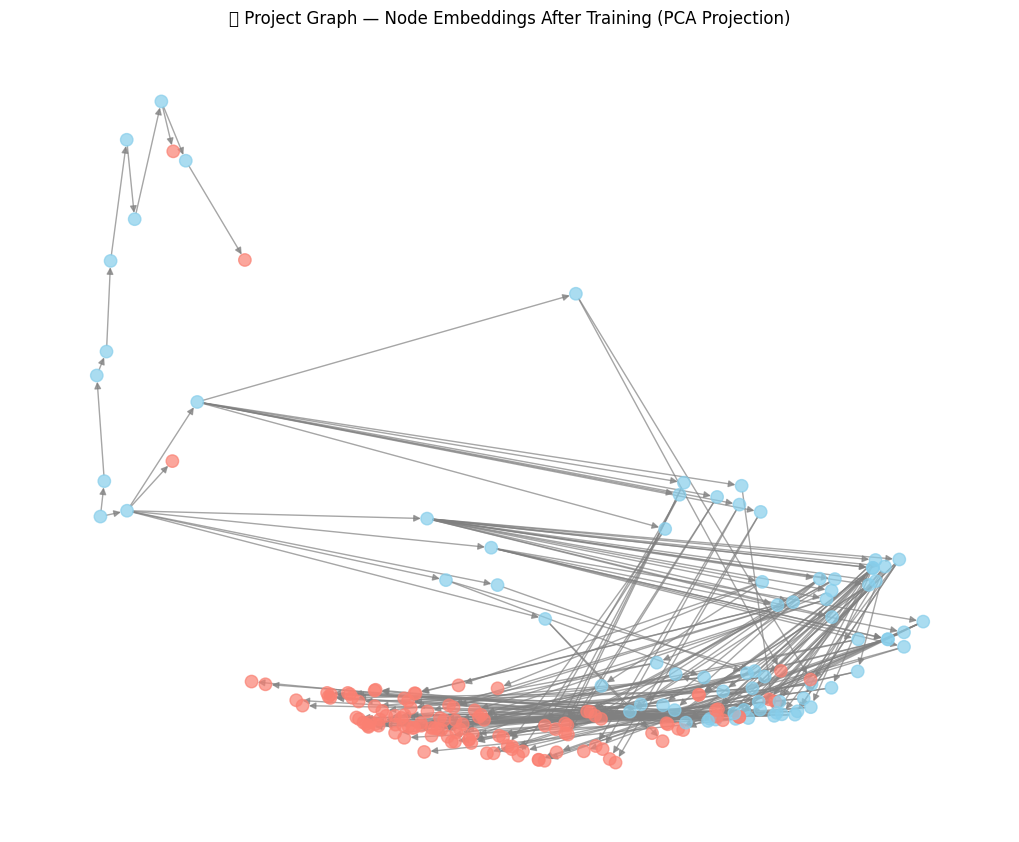

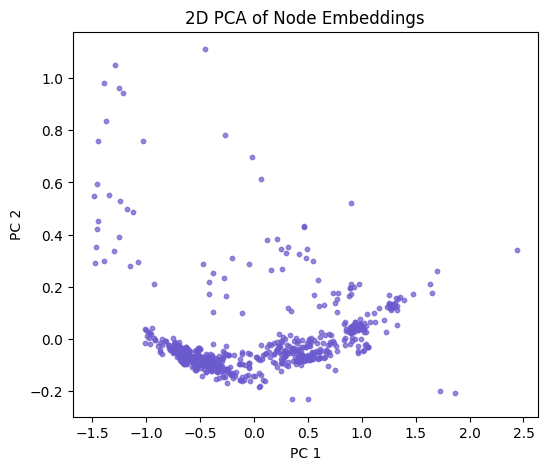

In [ ]:

# Visualize Learned Node Embeddings After Training

import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Load model + data again
data = torch.load("E:/Research/R004SE-PrefetchingGnn/user-session-sim/gnn_prefetch_dataset.pt", weights_only=False)
G = nx.read_gexf("E:/Research/R004SE-PrefetchingGnn/route-mapper/graph.gexf")

model = GNNPrefetch(data.x.size(1), 128, 64, num_layers=3, model_type="sage")
model.load_state_dict(torch.load("gnn_prefetch_linkpred.pt", weights_only=False))
model.eval()

# Get embeddings
with torch.no_grad():
    embeddings = model.get_embedding(data.x, data.edge_index).cpu().numpy()

# Reduce to 2D with PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

# Pick subset for clarity
num_nodes = len(G.nodes())
subset_size = min(200, num_nodes)
sub_nodes = list(G.nodes())[:subset_size]
sub_indices = [list(G.nodes()).index(n) for n in sub_nodes]

# Create mapping node -> position using the PCA result
pos = {n: emb_2d[i] for n, i in zip(G.nodes(), range(num_nodes))}

# Make subgraph
H = G.subgraph(sub_nodes).copy()

# Color directories vs files
colors = [
    "skyblue" if str(G.nodes[n].get("is_directory", "false")).lower() == "true" else "salmon"
    for n in H.nodes()
]

plt.figure(figsize=(10, 8))
nx.draw(
    H,
    pos={n: pos[n] for n in H.nodes() if n in pos},  # ✅ Safe lookup
    node_color=colors,
    node_size=80,
    edge_color="gray",
    alpha=0.7,
    with_labels=False,
)
plt.title("🔥 Project Graph — Node Embeddings After Training (PCA Projection)")
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c="slateblue", s=10, alpha=0.7)
plt.title("2D PCA of Node Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()
